<a href="https://colab.research.google.com/github/joohoshin/TensorflowAI/blob/main/18_3_Class_Activation_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Class Activation Map

https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/

https://junstar92.tistory.com/152

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
# Cats vs Dogs Dataset
tfds.disable_progress_bar()
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
# load the dataset given the splits defined above
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)
(train_examples, validation_examples, test_examples) = splits
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
BATCH_SIZE = 32
def normalize_and_resize(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.
  image = tf.image.resize(image, (224, 224))
  return image, label
# prepare batches
train_batches = train_examples.shuffle(num_examples // 4).map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_examples.map(normalize_and_resize).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_examples.map(normalize_and_resize).batch(1)

In [ ]:
def build_model():
  base_model = tf.keras.applications.VGG16(input_shape= (224, 224, 3), 
    weights='imagenet', include_top=False)
  # add a GAP layer
  output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  # output has two neurons for the 2 classes(dogs and cats)
  output = tf.keras.layers.Dense(2, activation='softmax')(output)
  # set the inputs and outputs of the model
  model = tf.keras.Model(base_model.input, output)
  for layer in base_model.layers[:-4]:
    layer.trainable = False
  model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])
  model.summary()
  return model
model = build_model()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
EPOCHS = 10
model.fit(train_batches, epochs=EPOCHS, validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 130s 199ms/step - loss: 8.7587 - acc: 0.6649 - val_loss: 0.1737 - val_acc: 0.9261
Epoch 2/10
582/582 [==============================] - 109s 181ms/step - loss: 0.2127 - acc: 0.9254 - val_loss: 0.2290 - val_acc: 0.9110
Epoch 3/10
582/582 [==============================] - 109s 181ms/step - loss: 0.1430 - acc: 0.9458 - val_loss: 0.1305 - val_acc: 0.9480
Epoch 4/10
582/582 [==============================] - 109s 181ms/step - loss: 0.1166 - acc: 0.9593 - val_loss: 0.1798 - val_acc: 0.9471
Epoch 5/10
582/582 [==============================] - 109s 181ms/step - loss: 0.1075 - acc: 0.9685 - val_loss: 0.1243 - val_acc: 0.9518
Epoch 6/10
582/582 [==============================] - 109s 181ms/step - loss: 0.0774 - acc: 0.9753 - val_loss: 0.1805 - val_acc: 0.9553
Epoch 7/10
582/582 [==============================] - 109s 181ms/step - loss: 0.0625 - acc: 0.9799 - val_loss: 0.1724 - val_acc: 0.9506
Epoch 8/10
582/582 [============================

In [ ]:
cam_model = tf.keras.Model(model.input, outputs=(model.layers[-3].output, model.layers[-1].output))
cam_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
class_weights = model.layers[-1].get_weights()[0]
class_weights.shape

(512, 2)

In [ ]:
imgs = []
lbls = []
for img, lbl in test_batches.take(1):
  imgs.append(img)
  lbls.append(lbl)

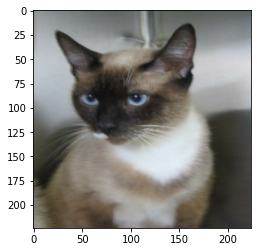

In [ ]:
img_np =tf.squeeze(imgs[0])
plt.imshow(img_np)

In [ ]:
features,results = cam_model.predict(img)

In [ ]:
features.shape

(1, 7, 7, 512)

In [ ]:
results.shape

(1, 2)

In [ ]:
label = results.argmax()

In [ ]:
features_for_img = features[0]
prediction = results[0]
class_activation_weigths = class_weights[:,label]

In [ ]:
class_activation_features = sp.ndimage.zoom(features_for_img, (224/7, 224/7, 1), order=2)

In [ ]:
class_activation_features.shape

(224, 224, 512)

In [ ]:
cam_output = np.dot(class_activation_features, class_activation_weigths)
  

In [ ]:
cam_output.shape

(224, 224)

In [ ]:
cam_output = tf.reshape(cam_output, (224,224))

cat


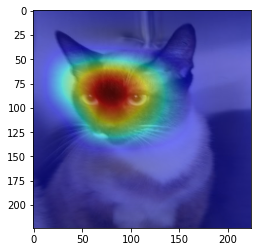

In [ ]:
class_name = 'dog' if tf.argmax(results[0]) else 'cat'
print(class_name)
plt.imshow(tf.squeeze(imgs[0]))
plt.imshow(cam_output, cmap='jet', alpha=0.5)  
plt.show()